<a href="https://colab.research.google.com/github/Femme-js/Denoising-Autoencoder-cifar-10/blob/master/Denoising_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
   Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import  cifar10

In [2]:
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data( )

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
#convert data to floats

train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.
len(train_data_clean)
len(test_data_clean)

10000

In [4]:
# Adding noise

def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data
train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

In [5]:

len(train_data_noisy)
len(test_data_noisy)

10000

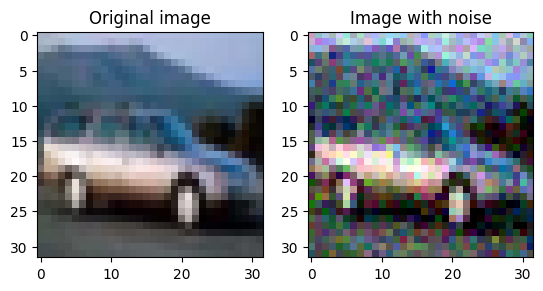

In [6]:
idx = 4
plt.subplot(1,2,1)
plt.imshow(train_data_clean[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_data_noisy[idx])
plt.title('Image with noise')
plt.show()

In [7]:

#Defining the architecture

def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [8]:
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [9]:
def denoising_autoencoder():
   dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)

   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3,
                       kernel_size=3,
                       padding='same')(deconv_block4)

   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)

   return Model(dae_inputs, dae_outputs, name='dae')


In [10]:
import keras.backend as K

# Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
def loss(y_true,y_pred):
    return K.mean(K.square(y_pred - y_true) + K.mean(y_pred), axis=-1)

    return loss

In [11]:
# Compiling the model

dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)

history = dae.fit(train_data_noisy[:9000], train_data_clean[:9000], validation_data = (test_data_noisy[9000:], test_data_clean[9000:]),

       epochs=100,
       batch_size=128,
       callbacks=[checkpoint])

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.5654
Epoch 1: val_loss improved from inf to 0.04765, saving model to best_model.h5
71/71 [==============================] - 15s 59ms/step - loss: 0.0120 - accuracy: 0.5654 - val_loss: 0.0477 - val_accuracy: 0.5527
Epoch 2/100
70/71 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.6902
Epoch 2: val_loss improved from 0.04765 to 0.03622, saving model to best_model.h5
71/71 [==============================] - 2s 22ms/step - loss: 0.0039 - accuracy: 0.6903 - val_loss: 0.0362 - val_accuracy: 0.5666
Epoch 3/100
70/71 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.7205
Epoch 3: val_loss improved from 0.03622 to 0.02331, saving model to best_model.h5
71/71 [==============================] - 2s 24ms/step - loss: 0.0032 - accuracy: 0.7206 - val_loss: 0.0233 - val_accuracy: 0.6262
Epoch 4/100
71/71 [==============================] - ETA: 0s - loss: 0.0029 - accu

313/313 [==============================] - 2s 4ms/step


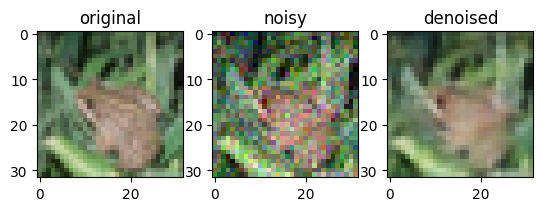

In [12]:
dae.load_weights('best_model.h5')
test_data_denoised = dae.predict(test_data_noisy)
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_data_clean[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()

In [13]:
#Evaluating the loss
def mse(data_1, data_2):
   return np.square(np.subtract(data_1, data_2)).mean()

noisy_clean_mse = mse(test_data_clean, test_data_noisy)
denoised_clean_mse = mse(test_data_denoised, test_data_clean)

noisy_clean_mse, denoised_clean_mse

(0.009306699487311346, 0.0018456447)

In [14]:
#Evaluating the model on test data
results = dae.evaluate(test_data_noisy, test_data_clean, verbose=0)

print("test loss, test accuracy :")
print(results)

test loss, test accuracy :
[0.0018456445541232824, 0.7840399146080017]


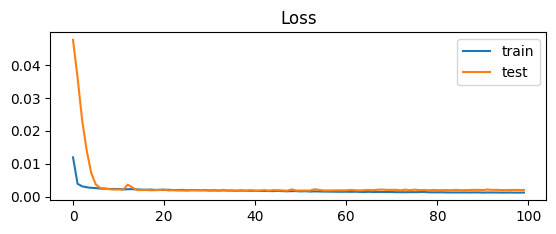

In [15]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()